# Notebook 1.1: Experimenting with Hash Tables

Before completing this notebook you should have completed your assigned reading, chapters 10.1 & 10.2 of [Data Structures and Algorithms in Python (Goodrich, Tamassia, & Goldwasser)](https://www.wiley.com/en-us/Data+Structures+and+Algorithms+in+Python%2C+1st+Edition-p-9781118290279), which includes text about Hash Functions, Collision-Handling Schemes, & Load Factors.

Storing and retrieving data is a fundamental operation in computer science. Hash tables are a very practical and efficient data structure for storing *key*:*value* pairs, and python implements this data structure with the `dict` class. As you advance in your career as a computer scientist, if you code in python you will make significant use of python dictionaries, so it's important to understand the details of how they work.

Follow along with the materials and execute code in this notebook to get a better understanding of the inner workings of **hash
functions**, which underlie this ubiquitous data structure.


In [ ]:
# As usual, start by loading required libraries
import matplotlib.pyplot as plt
import numpy as np

## Understanding properties of 'useful' hash functions

Recall from the reading that a *hash function* *h(k)* comprises two components:  
- A **hash code** that maps a key *k* to an integer, and
- A **compression function** that maps the hash code to an integer ([0, N-1]) for indexing into
our bucket array (of size *N*).

A very simple compression function is `mod N` (in python `% N`), and for the purpose of this exercise
that is what we will adopt, since we are focused on hashing for the moment.

Useful hash functions should strive for these properties:  
1. They should be deterministic
2. They should be efficient to compute
3. They should produce uniformly distributed hash values

In practice, the requirement of **determinism** is an 'iron rule' rather than a feature we can optimize over. Imagine using a hash table
to store your contact info. If your contacts hash table implemented a non-deterministic hash function you might look up the phone number for your mother and get returned the number for your childhood best friend! Not the worst case scenario, but definitely not 'The Desired Effect'™.

On the other hand, **efficiency** of computation and **uniformity** of distribution of hash values **are** features we can optimize over. One could imagine a very very efficient hash function with poor distribution of hash values (many collisions), or a very computationaly expensive hash function with perfect uniformity of distribution. Consider situations where one of these might have an advantage over the other.

*"There are no solutions. There are only trade-offs."*  
― Thomas Sowell, [A Conflict of Visions: Ideological Origins of Political Struggles](https://en.wikipedia.org/wiki/A_Conflict_of_Visions)

In this exercise we will explore the **efficiency**/**uniformity** tradeoff for a number of different 'cartoon' hash functions, so you can get the feel for what this means.

## Set up the input data

For this exercise we will use strings of text as the input data. We'll tokenize the strings (delimiting on
whitespace), compute hash functions for each word in the string, and evaluate runtime and hash value distributions.
We will use: a couple of choice nuggets from Knuth's magnum opus [The Art of Computer Programming](https://en.wikipedia.org/wiki/The_Art_of_Computer_Programming); a [*Lorem ipsum*](https://en.wikipedia.org/wiki/Lorem_ipsum) generator (for longer blocks of pseudo-random text); and a batch of uniformly distributed random integer values from numpy.

In [ ]:
from lorem_text import lorem

# The Art of Computer Programming, Vol. I
quote1 = """People who are more than casually interested in computers should 
have at least some idea of what the underlying hardware is like. Otherwise the programs 
they write will be pretty weird.""".split()

# The Art of Computer Programming, Vol III
quote2 = """It is especially important to know the average behavior of a hashing method, 
because we are committed to trusting in the laws of probability whenever we hash. 
The worst case of these algorithms is almost unthinkably bad, so we need to be 
reassured that the average is very good.""".split()

# One paragraph of random nonsense text
lorem_text = lorem.paragraphs(1).split()

# 1000 random integer values between 0 and 9999
randint_data = np.random.randint(0, 10000, 1000)

## Candidate hash functions

Here are several examples of functions that satisfy the definition of *hash codes* as proposed by the text,
i.e. a map between an input *key* and an integer *value*. I have isolated the hash codes here from the 
compression function (`% N`), but we'll pull this back in later when we implement the `my_hasher()` class,
to allow for flexibility in this size of the hash table index.

Think about how these functions will perform in terms of the 'useful properties' we discussed: Determinism, 
efficiency, & uniformity. Discuss with a partner which of these you think will perform 'best' overall, and 
why you think this. Be prepared to share with the class, and justify your choice.

In [ ]:
def hash_one(data):
    """For any input data return the integer 1"""
    return 1

def hash_random(data):
    """For any input data return a random integer [0, 100)"""
    return np.random.randint(100)

def hash_length(data):
    """Return the length (character count) of the input sequence"""
    # Cast to a string to allow passing in numerical values
    data = str(data)
    return len(data)

def hash_first(data):
    """Return the Unicode code point (integer value) of the first character of input"""
    # Cast to a string to allow passing in numerical values
    data = str(data)
    # `ord()` is a python built-in to get the integer value of a
    # single-character string
    return ord(data[0])

def hash_sum(data):
    """Return the sum of Unicode integer values of all characters of input"""
    data = str(data)
    return sum([ord(x) for x in data])

## Simple experiments with hash functions
Now spend some time testing your hypotheses about the behaviors of some of these hash functions using
the `quote1`, `quote2`, `lorem_text`, and `randint_data` variables we created previously. A very simple and
quick way to apply these functions to lists of items is to use *list comprehension* to apply a given function
across all elements of a list. Then you might consider using `Counter` from the python `collections` library, 
to count the number of occurrences of each hash value. (**NB:** `collections.Counter` is a sub-class of `dict`, 
as it stores key/values pairs as well!) 

In [ ]:
from collections import Counter

hashed = [hash_length(x) for x in quote2]
Counter(hashed)

## Define the `my_hasher()` class as a test harness

Because this is a teaching demonstration (and not the middle of an actual semester where we'd have been 
working together for weeks), I can't make assumptions about the python coding expertise of any given 
participant. But, because you all have CS backgrounds or are at least CS-adjacent, I hope it's fair to 
assume that I can expect you to be able to 'plug-and-chug' with a pre-baked test harness for evaluating
hash function behavior.

If you don't know python or are relatively new to coding, don't worry about the details of this class. 
You'll see how to pull the levers below, and it should be quite straightforward. Execute the next cell
to define this class.

In [ ]:
# We will use the `entropy()` function from scipy.stats to quantify
# uniformity of distribution of hash values, so import it here.
from scipy.stats import entropy

class my_hasher:
    """A simple class to wrap and evaluate hash function performance."""

    def __init__(self, size=10, hash_method=hash):
        """
        Parameters:
            size (int): The size of the hash table index
            hash_method (function): The hash code to apply (defaults to python `hash`).
        """
        self.size = size
        # A list for counting the number of collisions at a given index
        self.indices = [0] * size
        self.hash_method = hash_method

    def hash_data(self, data=[0,1,2,3,4,5,6,7,8,9]):
        """
        Apply the hash function (hash code plus compression) to each element 
        of the input data, and accumulate the number of 'hits' to a given index.

        Parameters:
            data (list): A list of elements to which the function will be applied.
                         List items must be strings or numerical.
        """
        for item in data:
            # Apply the hash function to each item
            hash_val = self.hash_method(item) % self.size
            self.indices[hash_val] += 1

    def evenness(self):
        """
        A simple way to quantify uniformity using information theory.

        Returns:
            A value between 0 and 1 (inclusive) representing the
            evenness of the distribution of hashes among the array bins.
            Values closer to 1 are more even.
        """
        return np.exp(entropy(self.indices))/self.size

    def plot(self):
        """Generate a bar plot of index content"""
        plt.bar(range(self.size), self.indices)
        plt.title(f"Evenness={m.evenness():.2f}")


### Simple-as-possible execution to demonstrate `my_hasher` class

We gave the `__init__()` and `hash_data()` methods sensible and simple
defaults, so we can create a new `my_hasher` object, hash some data, and plot the results
pretty frictionlessly to demonstrate the workflow.

In [ ]:
# Instantiate a new my_hasher object with defaults for size and hash_method
m = my_hasher()
# Hash the default data 
m.hash_data()
# Bar plot showing number of hits per array bin
m.plot()

### An interlude on `entropy`

The `entropy` function quantifies the average amount of 'surprise'
when sampling from a given set of outcomes. The surrounding `np.exp()`
and division by the number of potential states (`self.size`) rescale
the results to the unit interval [0, 1], representing the `evenness`
of distribution of index values. 

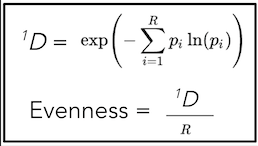

In the limit of no variation
among hash values evenness is 0 (left), and with perfect uniformity
evenness will be 1 (right), but in most cases it will be somewhere in
the middle (middle). These are cartoon examples, and no hash function
will ever achieve exactly perfect evenness but it's a nice goal.

*"Painters, do not fear perfection. You will never achieve it!"*.  
― Salvador Dalí, [The Paintings 1904-1946, Volume 1](https://www.google.com/books/edition/Salvador_Dal%C3%AD_1904_1989/AnRWAAAAYAAJ?hl=en)

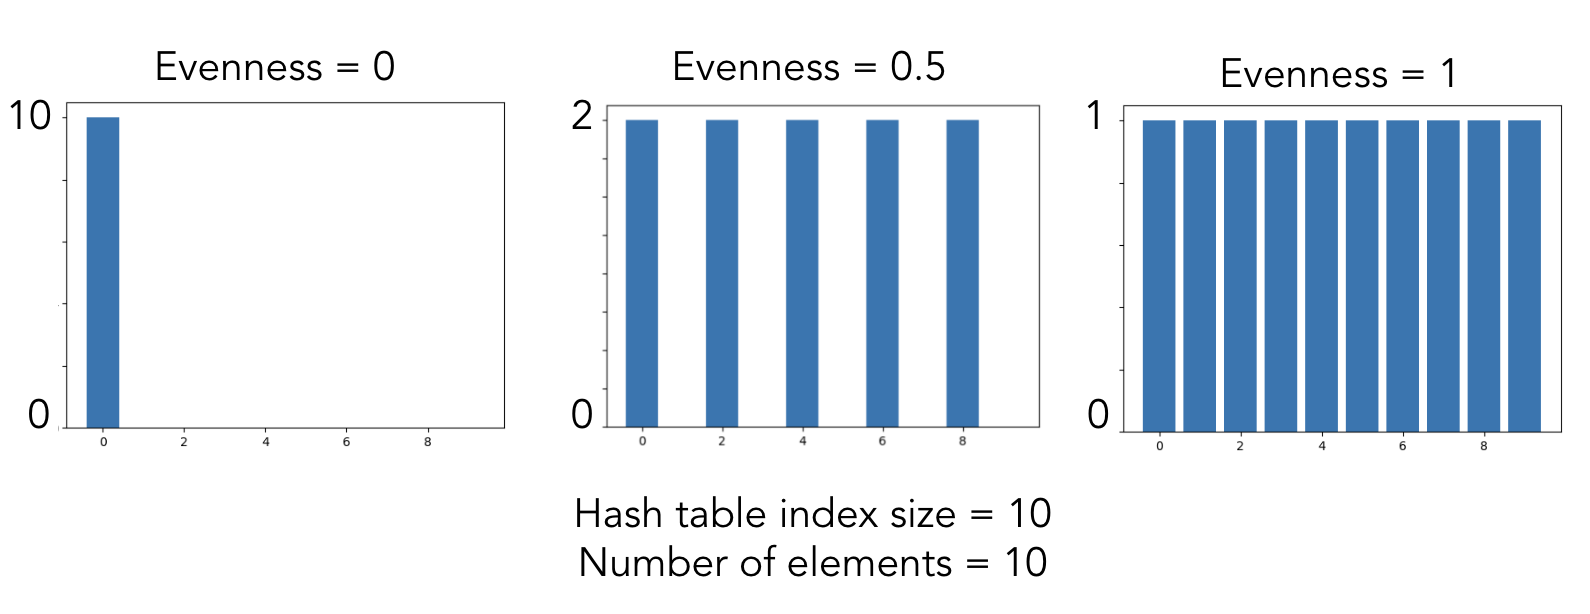

## Evaluating hash function performance
We can measure hash function **uniformity** with the `evenness()` function, so we need a rough way to measure
hash function **efficiency**. For this we can use a built-in jupyter notebook **magic** command called `%timeit`
which will run many iterations of a line of code and return runtime statistics.

In the following code cell I illustrate using the `%timeit` magic to run the function `test.hash_data(randint_text)`, 
passing in arguments for `-n` to execute this function 1000 times, and `-o` to return the timing results as a
`TimeitResult` object (which I store in the `time_result` variable), so I can programmatically access these.

In [ ]:
test = my_hasher(hash_method=hash_sum)
time_result = %timeit -n 1000 -o test.hash_data(randint_data)


# Hash function challenges

## Intro Challenge 
Create a new `my_hasher` object passing in one of the hash functions we defined above (`hash_length`,
`hash_first`, `hash_sum`) and evaluate it's uniformity (with the `evenness()` method) and efficiency 
(using the `%timeit` magic) on the 4 different datasets we defined (`quote1`, `quote2`, `lorem_text`, 
and `randint_data`). Is there a clear winner based on these two metrics?

## Intermediate Challenge
Loop over the available hash functions and the 4 datasets and calculate `evenness()` and average runtime (using 
the `%timeit` magic) for each combination of these. Format the output as a dictionary of dictionaries, with the 
first key being the hash function, the secondary key being the dataset ID, and the values of the nested dictionaries 
being a tuple of evenness and average runtime results. Is there a hash function that performs best on all input datasets?

## Advanced Challenge
Follow the format of the calls to `lorem.paragraphs()` and/or `np.random.randint()` as shown above to generate 10 
datasets of increasing size. Evaluate `evenness()` and runtime performance (using the `%timeit` magic) for one of 
the hash functions above (whichever you think is best) and compare this to the native python `hash()` function. 
Generate 2 figures with dataset size on the x-axis, and evaluation metric on the y-axis. Be prepared to interpret 
your results.

<div class="alert alert-success">
    Congrats you have finished the notebook. There is no assessment here.
</div>